# Time Series Prediction with LSTM

#### Hyperparameter Tuning Exp 1: Tune the LSTM network architecture and configuration

#Steps
1. Get the stock data using RobinHood instead of Quandl
2. Add Technical Indicators
3. Combine to create a feature vector
4. Convert to series
6. Test different LSTM Model
7. Build the model
8. Look at results

Notes:
- Robinhood only give 256 days of data (roughly one year) BUT latest data (Predict on this)
- Quandl give historical data but not the recent data (Train on this!)

In [1]:
!pip install TA-lib
!pip install quandl
import talib as ta
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import seaborn as sns
%matplotlib inline

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

def getData(sym,startdate, enddate, choice=1):
    if choice == 1:
        df = web.DataReader(sym,'robinhood', startdate, enddate)
        #df = web.DataReader('VDE','robinhood', startdate, enddate)
        #df.set_index('begins_at')
        df = df.drop(['interpolated','session'], axis=1)
        df = df.rename(index=str, columns={"close_price": "Close", "high_price": "High","low_price":"Low","open_price":"Open","volume":"Volume"})
    else:
        import quandl 
        quandl.ApiConfig.api_key = "8zKAkyPxYjMss6sbu_E2"
        df = quandl.get('WIKI/'+sym,start_date=startdate,end_date=enddate, returns='pandas')
        df = df.drop(['Open','High','Low','Close','Volume','Ex-Dividend','Split Ratio'], axis=1)
        df = df.rename(index=str, columns={"Adj. Close": "Close", "Adj. High": "High","Adj. Low":"Low","Adj. Open":"Open","Adj. Volume":"Volume"})
    return df

#### Use Quandl api 

import quandl
quandl.ApiConfig.api_key = "8zKAkyPxYjMss6sbu_E2"

#data = quandl.get('WIKI/GOOG',start_date=startdate,end_date=enddate, returns='pandas')

Get the stock data and only keep the columns that will be used

In [3]:
def getStockData(sym, startdate, enddate):
    mydata = quandl.get('WIKI/'+sym,start_date=startdate,end_date=enddate, returns='pandas')
    mydata = mydata.drop(['Open','High','Low','Close','Volume','Ex-Dividend','Split Ratio'], axis=1)
    return mydata

Get the VIX volatility data and remove the columns that are not needed

In [4]:
def getVIXData(startdate, enddate):
    vixdata = quandl.get('CHRIS/CBOE_VX1',start_date=startdate,end_date=enddate, returns='pandas')
    vixdata = vixdata.drop(['Open','High','Low','Settle','Change','Total Volume','EFP', 'Prev. Day Open Interest'], axis=1)
    vixdata.rename(columns={"Close": "VIX"}, inplace=True)
    return vixdata

Calculate select technical indicators and add as features

In [5]:
def calcIndicators(mydata, priceName, volName):
    # adding 9 additional features 
    
    #mydata['BB_up'], mydata['BB_mid'],mydata['BB_low'] = ta.BBANDS(np.asarray(mydata['Close']), 20)

    # Lagging Indictors (Trend)
    mydata['EMA_50'] = ta.EMA(mydata[priceName], 50)
    mydata['EMA_100'] = ta.EMA(mydata[priceName], 100)
    mydata['EMA_200'] = ta.EMA(mydata[priceName], 200)
    #mydata['SMA_200'] = ta.EMA(np.asarray(mydata[priceName]), 200)

    # Oscillators (Momentum)
    mydata['RSI'] = ta.RSI(mydata[priceName],14)
    mydata['STO_k'], mydata['STO_d'] = ta.STOCHF(np.asarray(mydata['High']), np.asarray(mydata['Low']), \
                                     np.asarray(mydata['Close']), fastk_period=5, fastd_period=3, fastd_matype=0)
    mydata['Macd'], mydata['Macdsignal'], mydata['Macdhist'] = ta.MACD(mydata[priceName],  \
                                                        fastperiod=12, slowperiod=26, signalperiod=9)

    # Volume Indicators
    mydata['MFI'] = ta.RSI(mydata[priceName],14)
    mydata['OBV'] = ta.OBV(mydata[priceName],mydata[priceName])
    #mydata['OBV_50'] = ta.EMA(np.asarray(mydata['OBV']), 50)
    #mydata['OBV_100'] = ta.EMA(np.asarray(mydata['OBV']), 100)
    #mydata['OBV_200'] = ta.EMA(np.asarray(mydata['OBV']), 200)
    
    #drop all the NaN rows
    mydata.dropna(inplace=True)

Merge (outer join) the stock feature dataframe with VIX dataframe using the time index, drop all the NaN rows

In [6]:
def mergeColumns(stockdata,vixdata):
    newdata = pd.concat([stockdata,vixdata],axis =1)
    newdata.dropna(inplace=True)
    return newdata

In [7]:
def addTarget(data,targetName,days):
    #a.x2 = a.x2.shift(1)
    data['Target']= data[targetName].shift(days)
    data.dropna(inplace=True)
    data = data.astype('float32')
    #print(data)
    #print('--------')
    
    # need to return a numpy array rather than pandas dataframe
    return data.values

Normalize the feature vector for use by the classifier

In [8]:
def normalizeData(data):
    # Rescale all the vales in the table
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaler, scaled

Split data into training and Test

In [9]:
def trainingTestSplit(scaled, trainRatio):
    n_train_hours = int(len(scaled) * trainRatio)
    train = scaled[:n_train_hours, :]
    test = scaled[n_train_hours:, :]
    
    # split into input and outputs
    train_X, train_Y = train[:, :-1], train[:, -1]
    test_X, test_Y = test[:, :-1], test[:, -1]
    print('train X,Y, testX,Y:',train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
    
    #reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    #print(type(test_X))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print('After reshape:', train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
    
    return train_X, train_Y, test_X, test_Y

In [10]:
def createModel(train_X,train_Y,test_X,test_Y):
    # seven layers to remember 7 dats
    model = Sequential()    
    model.add(LSTM(16, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))  
    model.add(LSTM(32,return_sequences = True))
    model.add(LSTM(64,return_sequences = True))
    model.add(LSTM(128,return_sequences = True))
    model.add(LSTM(64,return_sequences = True))
    model.add(LSTM(32,return_sequences = True))
    model.add(LSTM(16))
    # output layer
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    
    return model

Test model predictions against the test data

In [11]:
def testModel(model, test_X,test_Y):
    #print(test_X[:5])
    yhat = model.predict(test_X)
    print(yhat.shape)
    pyplot.plot(yhat, label='predict')
    pyplot.plot(test_Y, label='true')
    pyplot.legend()
    pyplot.show()
    
    return yhat

#### Scaler Inverse Y back to normal value

In [12]:
def calcPredError(test_X, test_Y, yhat, scaler):
    
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  
    # invert scaling for forecast
    test_X = np.concatenate((test_X,yhat),axis=1)
    inv_yhat = scaler.inverse_transform(test_X)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_Y = test_Y.reshape((len(test_Y), 1))
    inv_y = concatenate((test_Y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    return rmse

Main Function

In [17]:
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

from datetime import date, timedelta
enddate = date.today().strftime('%Y-%m-%d')
print(enddate)
startdate = (date.today() - timedelta(2160)).strftime('%Y-%m-%d')
print(startdate)

sym = 'GOOG'
trainRatio = 0.85
num_epoch = 50
daysShift = 7 # -1 Predict on day ahead, -2 2 days ahead...

#mydata =  getStockData(sym, startdate, enddate)
# 1 = data from Robinhood 0 == data from quandl
mydata = getData(sym,startdate, enddate,0)
print('Original Data shape:',mydata.shape)

#vixdata = getVIXData(startdate, enddate)
calcIndicators(mydata, 'Close', 'Volume')
print('After TA Indicators Data shape:',mydata.shape)
#newdata = mergeColumns(mydata,vixdata)
#print('Feature Vectors shape prior train/test split:',newdata.shape)
#newdata.tail()

features = addTarget(mydata,'Close',daysShift)
scaler, scaled = normalizeData(features)

train_X, train_Y, test_X, test_Y = trainingTestSplit(scaled, trainRatio)

lstm_model = createModel(train_X,train_Y,test_X,test_Y)
lstm_pred = lstm_model.fit(train_X, train_Y, epochs=num_epoch, batch_size=64, validation_data=(test_X, test_Y))

scores = lstm_model.evaluate(test_X, test_Y, verbose=0)
print("%s: %.2f%%" % (lstm_model.metrics_names[1], scores[1]*100))


2018-10-26
2012-11-26
Original Data shape: (1007, 5)
After TA Indicators Data shape: (808, 16)
train X,Y, testX,Y: (680, 16) (680,) (121, 16) (121,)
After reshape: (680, 1, 16) (680,) (121, 1, 16) (121,)
Train on 680 samples, validate on 121 samples
Epoch 1/50
680/680 [==============================] - 8s 12ms/step - loss: 0.1485 - acc: 0.0015 - val_loss: 0.6375 - val_acc: 0.0000e+00
Epoch 2/50
680/680 [==============================] - 1s 1ms/step - loss: 0.1268 - acc: 0.0015 - val_loss: 0.5725 - val_acc: 0.0000e+00
Epoch 3/50
680/680 [==============================] - 1s 1ms/step - loss: 0.0967 - acc: 0.0015 - val_loss: 0.4552 - val_acc: 0.0000e+00
Epoch 4/50
680/680 [==============================] - 1s 1ms/step - loss: 0.0516 - acc: 0.0015 - val_loss: 0.1902 - val_acc: 0.0000e+00
Epoch 5/50
680/680 [==============================] - 1s 1ms/step - loss: 0.0341 - acc: 0.0015 - val_loss: 0.1914 - val_acc: 0.0000e+00
Epoch 6/50
680/680 [==============================] - 1s 1ms/step - l

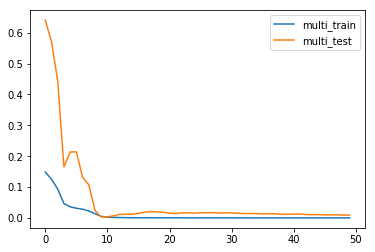

(121, 1)


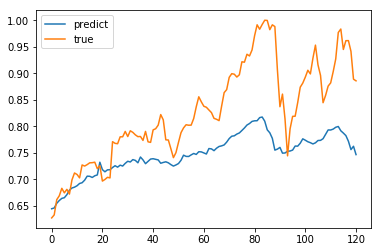

Test RMSE: 38.418


38.417903414090354

In [16]:
# plot results
pyplot.plot(lstm_pred.history['loss'], label='multi_train')
pyplot.plot(lstm_pred.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

yhat = testModel(lstm_model, test_X,test_Y)
calcPredError(test_X, test_Y, yhat, scaler)